<a href="https://colab.research.google.com/github/danphan/Earth-Surface-Water-Image-Segmentation/blob/main/Earth_surface_water.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://zenodo.org/record/5205674/files/dset-s2.zip

--2023-03-08 09:07:12--  https://zenodo.org/record/5205674/files/dset-s2.zip
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 611792578 (583M) [application/octet-stream]
Saving to: ‘dset-s2.zip’

dset-s2.zip         100%[===================>] 583.45M  4.44MB/s    in 2m 12s  

2023-03-08 09:09:24 (4.44 MB/s) - ‘dset-s2.zip’ saved [611792578/611792578]



In [2]:
!unzip dset-s2.zip

Archive:  dset-s2.zip
   creating: dset-s2/
  inflating: __MACOSX/._dset-s2      
   creating: dset-s2/tra_truth/
   creating: dset-s2/val_truth/
   creating: dset-s2/tra_scene/
   creating: dset-s2/val_scene/
  inflating: dset-s2/tra_truth/S2A_L2A_20190817_N0213_R089_S1_Truth.tif  
  inflating: dset-s2/tra_truth/S2B_L2A_20190818_N0213_R035_S1_Truth.tif  
  inflating: dset-s2/tra_truth/S2A_L2A_20190716_N0213_R063_S3_Truth.tif  
  inflating: dset-s2/tra_truth/S2A_L2A_20190314_N0211_R008_S1_Truth.tif  
  inflating: dset-s2/tra_truth/S2B_L2A_20190807_N0213_R018_S2_Truth.tif  
  inflating: dset-s2/tra_truth/S2B_L2A_20190904_N0213_R132_S2_Truth.tif  
  inflating: dset-s2/tra_truth/S2A_L2A_20190811_N0213_R013_S2_Truth.tif  
  inflating: dset-s2/tra_truth/S2B_L2A_20190506_N0212_R126_S3_Truth.tif  
  inflating: dset-s2/tra_truth/S2A_L2A_20190206_N0211_R067_S1_Truth.tif  
  inflating: dset-s2/tra_truth/S2A_L2A_20190125_N0211_R034_S1_Truth.tif  
  inflating: dset-s2/tra_truth/S2B_L2A_20191023_N0

In [3]:
!pip install -q rioxarray torchgeo torchgeometry > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.


In [60]:
from pathlib import  Path
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import torch 
from torchgeo.samplers import RandomGeoSampler
from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples
from torchgeo.samplers import RandomGeoSampler, Units
from torchvision import transforms
from torch.utils.data import DataLoader
import timm
import numpy as np
from torchvision.models import resnet50, ResNet50_Weights
from torchmetrics import JaccardIndex
from torchgeometry.losses import DiceLoss
from torch.optim.lr_scheduler import PolynomialLR
import kornia.augmentation as K


import logging
# this line is to avoid warnings from Rasterio to be printed on screen
# the warning is explained here: https://stackoverflow.com/questions/74089170/suppress-rasterio-warning-warning-1-tiffreaddirectory
logger = logging.getLogger("rasterio")
logger.setLevel(logging.ERROR)
     
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [61]:
root = Path('dset-s2')
assert root.exists()

train_imgs = list((root/'tra_scene').glob('*.tif'))
train_masks = list((root/'tra_truth').glob('*.tif'))

val_imgs = list((root/'val_scene').glob('*.tif'))
val_masks = list((root/'val_truth').glob('*.tif'))

# As the images and corresponding masks are matched by name, we will sort both lists to keep them synchronized.
train_imgs.sort(); train_masks.sort()
val_imgs.sort(); val_masks.sort()

In [62]:
#number of training images
print(f'Number of training images: {len(train_imgs)}')
print(f'Number of validation images: {len(val_imgs)}')

Number of training images: 64
Number of validation images: 31


In [63]:
idx = 0
img = rio.open_rasterio(train_imgs[idx])
mask = rio.open_rasterio(train_masks[idx])

img.data.shape, mask.data.shape

((6, 764, 868), (1, 764, 868))

Each image has 6 channels, corresponding to the different frequency bands used by the Satellite to image the scene.

Note: The satellite images have 13 bands, but the authors of this dataset have disregarded the lowest-frequency (i.e. low resolution) channels, leaving 4 10-meter resolution and 2 20-meter resolution bands.

Check to see if the coordinate systems for each tiff file are the same

In [64]:
crs_list = set()
img_sizes = set()

for img_path, mask_path in zip(train_imgs, train_masks):
  img_opened = rio.open_rasterio(img_path)
  crs_list.add(img_opened.rio.crs);
  img_sizes.add(img_opened.shape)

In [65]:
crs_list

{CRS.from_epsg(32612),
 CRS.from_epsg(32615),
 CRS.from_epsg(32621),
 CRS.from_epsg(32625),
 CRS.from_epsg(32630),
 CRS.from_epsg(32635),
 CRS.from_epsg(32636),
 CRS.from_epsg(32637),
 CRS.from_epsg(32642),
 CRS.from_epsg(32647),
 CRS.from_epsg(32649),
 CRS.from_epsg(32651),
 CRS.from_epsg(32653),
 CRS.from_epsg(32658),
 CRS.from_epsg(32720),
 CRS.from_epsg(32754)}

There is more than one CRS-- these coordinate systems correspond to places around the world, from North America, through Europe, and into Australia. For consistency, we will project all of the images into the same coordinate system (World Mercator) (with the understandable caveat that images far from this Euro-centric centering will be distorted.) However, the World Mercator projection will hopefully minimize the magnitude of these distortions.

In [66]:
img_sizes

{(6, 545, 625),
 (6, 583, 673),
 (6, 634, 684),
 (6, 634, 701),
 (6, 675, 693),
 (6, 695, 821),
 (6, 734, 775),
 (6, 740, 874),
 (6, 746, 800),
 (6, 750, 756),
 (6, 764, 868),
 (6, 771, 840),
 (6, 774, 819),
 (6, 783, 913),
 (6, 792, 814),
 (6, 804, 898),
 (6, 807, 927),
 (6, 819, 804),
 (6, 847, 868),
 (6, 851, 966),
 (6, 859, 913),
 (6, 882, 889),
 (6, 910, 987),
 (6, 918, 1005),
 (6, 933, 1019),
 (6, 943, 976),
 (6, 943, 1016),
 (6, 943, 1042),
 (6, 946, 956),
 (6, 947, 1007),
 (6, 958, 1090),
 (6, 959, 1024),
 (6, 966, 977),
 (6, 967, 1036),
 (6, 968, 1032),
 (6, 983, 1038),
 (6, 989, 1000),
 (6, 993, 1103),
 (6, 1004, 1103),
 (6, 1005, 1082),
 (6, 1022, 1184),
 (6, 1023, 1089),
 (6, 1023, 1103),
 (6, 1041, 1117),
 (6, 1048, 1121),
 (6, 1056, 1056),
 (6, 1062, 1194),
 (6, 1098, 1164),
 (6, 1104, 1248),
 (6, 1112, 1198),
 (6, 1132, 1178),
 (6, 1135, 1035),
 (6, 1163, 1208),
 (6, 1178, 1274),
 (6, 1197, 1229),
 (6, 1207, 1241),
 (6, 1252, 1305),
 (6, 1269, 1334),
 (6, 1274, 1313),
 (

As we can see, there are a wide range of image sizes. Later, when constructing our architecture, we will make a network which takes as input square images of size 512x512.

For now, let's look at a few images and their masks.

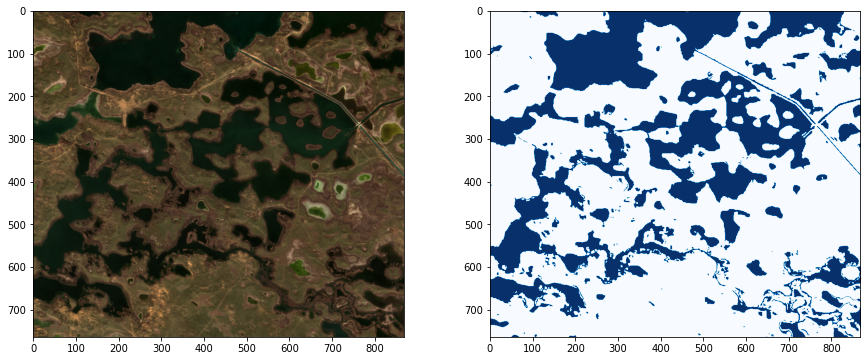

In [67]:
_, axs = plt.subplots(1, 2, figsize=(15, 6))

# plot the tile
#data indexing is to pick out the RGB channels, transpose is to make the color channels in the last slot of the array
rgb = img.data[[2, 1, 0]].transpose((1, 2, 0))/3000
axs[0].imshow(rgb.clip(min=0, max=1))

# plot the mask
axs[1].imshow(mask.data.squeeze(), cmap='Blues'); #squeeze() removes dimension-1 indices.

Let's look at the 6 different channels in the image

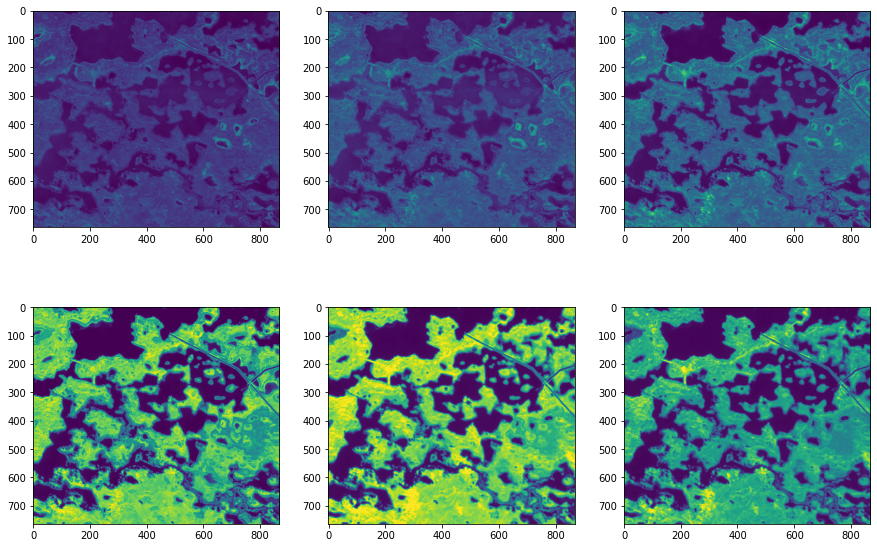

In [68]:
_, axs = plt.subplots(2, 3, figsize=(15, 10))
for i in range(2):
  for j in range(3):
    k = i*3+j
    # plot the tile
    rgb = img.data[k]/3000
    axs[i,j].imshow(rgb.clip(min=0, max=1))



We now would like to preprocess the images for the training dataset. To do so, we will do the following to the training images:

1. Convert the image (and mask) into the correct CRS projection.
2. Change the channels to be in the last index (for both the image and mask).
3. Scale the image by 1e4
3. Randomly sample L squares of the image of size (crop_size, crop_size) of both the image and mask.

In [69]:
# this is to get the same result in every pass
torch.manual_seed(0)

crs_wm = 'EPSG:3395'
img_size = 512
batch_size = 16

def scale(item: dict):
  item['image'] = item['image']/2e3
  return item

def turn_rgb(item: dict):
  item['image'] = item['image'][[2,1,0]]
  item['image'][0] 
  return item

#means and std for imagenet taken from https://github.com/pytorch/examples/blob/97304e232807082c2e7b54c597615dc0ad8f6173/imagenet/main.py#L197-L198
mean = torch.Tensor([0.485, 0.456, 0.406])
std  = torch.Tensor([0.229, 0.224, 0.225])

def normalize_scale(item: dict):
  item['image'] = (item['image']-mean.view(-1,1,1))/std.view(-1,1,1)
  return item

def revert_scale(item: dict):
  if item['image'].dim == 3:
    item['image'] = item['image']*std.view(-1,1,1) + mean.view(-1,1,1)
  else:
    item['image'] = item['image']*std.view(1,-1,1,1) + mean.view(1,-1,1,1)
  return item



# train_imgs = RasterDataset(root=(root/'tra_scene').as_posix(), crs='epsg:3395', res=10, 
#                            transforms = transforms.Compose(
#                                [transforms.Lambda(lambda x: turn_rgb(x)),
#                                 transforms.Lambda(lambda x: scale(x)),
#                                 transforms.Lambda(lambda x: normalize_scale(x))])) #the bands we are working with have a resolution of 10 meters
# train_masks = RasterDataset(root=(root/'tra_truth').as_posix(), crs='epsg:3395', res=10)

# #Make sure the masks are not classified as images in the dictionary
# train_masks.is_image = False

# #define sampler that randomly picks out images from the dataset
# #choose 100 random squares of size 512 x 512
# #make sure the size is in pixels (Units.PIXELS), not CRS units
# sampler = RandomGeoSampler(train_imgs, size=(img_size, img_size), length=100, units = Units.PIXELS)

# #combine the training images and masks into one dataset
# train_dset = train_imgs & train_masks

In [16]:
def create_dataloader(scene_paths, mask_paths):
  imgs = RasterDataset(root=(root/scene_paths).as_posix(), crs='epsg:3395', res=10, 
                            transforms = transforms.Compose(
                                [transforms.Lambda(lambda x: turn_rgb(x)),
                                  transforms.Lambda(lambda x: scale(x)),
                                  transforms.Lambda(lambda x: normalize_scale(x))])) #the bands we are working with have a resolution of 10 meters
  masks = RasterDataset(root=(root/mask_paths).as_posix(), crs='epsg:3395', res=10)

  #Make sure the masks are not classified as images in the dictionary
  masks.is_image = False

  #define sampler that randomly picks out images from the dataset
  #choose 100 random squares of size 512 x 512
  #make sure the size is in pixels (Units.PIXELS), not CRS units
  sampler = RandomGeoSampler(imgs, size=(img_size, img_size), length=100, units = Units.PIXELS)

  #combine the images and masks into one dataset
  dset = imgs & masks

  dataloader = DataLoader(dset, sampler=sampler, batch_size=batch_size, collate_fn=stack_samples)
  return dataloader

In [17]:
train_dataloader = create_dataloader('tra_scene','tra_truth')
val_dataloader = create_dataloader('val_scene','val_truth')

Let's take a closer look at one batch of the dataloader.

In [18]:
batch = next(iter(train_dataloader))
batch.keys()

dict_keys(['crs', 'bbox', 'image', 'mask'])

We see that each batch has the CRS (here, World Mercator), bounding boxes (in CRS units), and the image/mask tensors.

In [19]:
batch['image'].shape

torch.Size([16, 3, 512, 512])

In [20]:
for batch in train_dataloader:
  X = batch['image']
  print(torch.mean(X), torch.std(X))

tensor(-0.0965) tensor(1.5481)
tensor(-0.3410) tensor(1.5083)
tensor(-0.0175) tensor(2.6801)
tensor(0.6450) tensor(3.6046)
tensor(-0.9173) tensor(1.1563)
tensor(-0.1276) tensor(1.7989)
tensor(-0.7698) tensor(1.5917)


Note that the channels index comes before the image width and height channels. This channels-first convention is different from the tensorflow convention, which uses channels-last.

Let's look at one of the images in the batch.

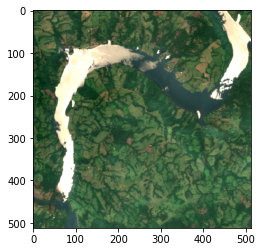

In [21]:
batch_rescaled = revert_scale(batch)
img = batch_rescaled['image'][0]
arr = torch.clamp(img, min=0, max=1).numpy()
rgb = arr.transpose(2, 1, 0)

plt.imshow(rgb)

In [22]:
model = resnet50(weights = ResNet50_Weights.DEFAULT)
# model = timm.create_model("resnet50", in_chans=in_chans)
# model.load_state_dict(weights.get_state_dict(progress=True), strict=False)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [23]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
test_tensor = torch.ones(1,3,512,512)

Now we have a ResNet encoder. Let's construct a decoder class.

In [25]:
class ConvBlock(torch.nn.Module):
  """
  Standard Convolutional layer, including batch normalization and RELU. Also, I've added a skip connection.
  """
  def __init__(self, num_inputs, num_filters, kernel_size, stride, padding, dilation = False, bn = True, transpose = False):
    super().__init__()

    if transpose:
      self.convlayer = torch.nn.ConvTranspose2d(num_inputs, num_filters, kernel_size = kernel_size, stride = stride, padding = padding, dilation = dilation, output_padding=1)
    else:
      self.convlayer = torch.nn.Conv2d(num_inputs, num_filters, kernel_size = kernel_size, stride = stride, padding = padding)

    torch.nn.init.kaiming_uniform_(self.convlayer.weight, a=np.sqrt(5))
    self.bn_layer = torch.nn.BatchNorm2d(num_filters) if bn else None
    self.act_layer = torch.nn.ReLU()

  def forward(self, x):
    conved = self.convlayer(x)
    out = self.bn_layer(conved) if self.bn_layer else conved
    return self.act_layer(out) + conved
    
class DoubleConvBlock(torch.nn.Module):
  def __init__(self, channels, kernel_size, stride, padding):
    super().__init__()
    self.conv1 = ConvBlock(channels[0], channels[1], kernel_size = kernel_size, stride = stride, padding = padding)
    self.conv2 = ConvBlock(channels[1], channels[2], kernel_size = kernel_size, stride = stride, padding = padding)

  def forward(self, x):
    out = self.conv1(x)
    out = self.conv2(out)
    return out 


In [26]:
class UNetCustom(torch.nn.Module):
  def __init__(self, encoder):
    super().__init__()

    self.conv1 = encoder.get_submodule('conv1')
    self.bn1 = encoder.get_submodule('bn1')
    self.relu = encoder.get_submodule('relu')
    self.maxpool = encoder.get_submodule('maxpool')
    self.layer1 = encoder.get_submodule('layer1')
    self.layer2 = encoder.get_submodule('layer2')
    self.layer3 = encoder.get_submodule('layer3')
    self.layer4 = encoder.get_submodule('layer4')

    self.conv0 = DoubleConvBlock([3, 64, 64], kernel_size = 3, stride = 1, padding = 1)

    self.up1 = ConvBlock(num_inputs = 2048, num_filters = 1024, kernel_size = 1, stride = 1, padding = 0) #cut filters in half #x
    self.up2 = torch.nn.Upsample(32)
    self.dconv1 = DoubleConvBlock([2048,1024,512], kernel_size = 3, stride = 1, padding = 1) #to apply post-concat #x output is 512x32x32
    
    self.up3 = torch.nn.Upsample(64) #output is 512x64x64
    self.dconv2 = DoubleConvBlock([1024, 512,256], kernel_size = 3, stride = 1, padding = 1) #to apply post-concat #output is 256x64x64

    self.up4 = torch.nn.Upsample(128) #output is 256x128x128
    self.dconv3 = DoubleConvBlock([512, 256, 128], kernel_size = 3, stride = 1, padding = 1) #to apply post-concat #output is 128x128x128


    self.up5 = ConvBlock(num_inputs = 128, num_filters = 64, kernel_size = 1, stride = 1, padding = 0) #reduce filters by 2 again
    self.up6 = torch.nn.Upsample(256) #output is 128x256x256
    self.dconv4 = DoubleConvBlock([128,64, 64], kernel_size = 3, stride = 1, padding = 1)


    self.up7 = torch.nn.Upsample(512) #output is 64x512x512
    self.dconv5 = DoubleConvBlock([128, 64, 64], kernel_size = 3, stride = 1, padding = 1)

    #final layer, to apply post-concat
    self.dconv6 = torch.nn.Conv2d(64,2, kernel_size = 1) #doing binary classification

  def forward(self, input_tensor):
    #input tensor has shape 13x512x512
    same = self.conv0(input_tensor)

    down1 = self.conv1(input_tensor) #conv1 --> torch.Size([4, 64, 256, 256])
    down1 = self.bn1(down1) #bn1 --> torch.Size([4, 64, 256, 256])
    down1 = self.relu(down1) 

    down2 = self.maxpool(down1) #maxpool --> torch.Size([4, 64, 128, 128])
    down2 = self.layer1(down2) # layer1 --> torch.Size([4, 256, 128, 128])

    down3 = self.layer2(down2) # layer2 --> torch.Size([4, 512, 64, 64])
    down4 = self.layer3(down3) # layer3 --> torch.Size([4, 1024, 32, 32])
    down5 = self.layer4(down4) # layer4 --> torch.Size([4, 2048, 16, 16])

    u1 = self.up2(self.up1(down5)) #--> shape [4,1024,32,32]
    u1 = self.dconv1(torch.cat([down4, u1], dim = 1)) #[4,512,32,32]

    u2 = self.up3(u1)    #--> shape [4,512,64,64]
    u2 = self.dconv2(torch.cat([down3, u2], dim = 1)) #[4,256,64,64]

    u3 = self.up4(u2) #[4,256,128,128]
    u3 = self.dconv3(torch.cat([down2, u3], dim = 1)) #[128,128,128]

    u4 = self.up6(self.up5(u3)) #[128,256,256]
    catted = torch.cat([down1, u4], dim = 1)
    u4 = self.dconv4(catted) #[64,256,256]

    u5 = self.up7(u4) #[64,512,512]
    u5 = self.dconv5(torch.cat([same, u5], dim = 1)) #[64,512,512]
    
    #final layer
    return self.dconv6(u5)

In [27]:
def training_loop(epochs, train_dl, val_dl, model, loss_fn, optimizer, scheduler):

  train_losses = []
  val_losses = []
  train_ious = []
  val_ious = []

  cuda_model = model.cuda()

  for epoch in range(epochs):
    accum_loss = 0
    iou = 0
    for batch in train_dl:
      X = batch['image'].cuda()
      y = batch['mask'].squeeze(dim = 1).type(torch.long).cuda()
      pred = cuda_model(X)
      loss = loss_fn(pred, y)

      #update loss
      accum_loss += float(loss) / len(train_dl)
      iou += JaccardIndex(num_classes = 2, task = 'multiclass')(pred.cpu(), y.cpu())/len(train_dl)

      #Backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    print(f'Epoch {epoch}')
    print(f'train loss: {accum_loss:.5f}')
    print(f'train IOU: {iou:.5f}')

    train_losses.append(accum_loss)
    train_ious.append(float(iou))

    if val_dl is not None:
      val_loss = 0
      iou = 0
      with torch.no_grad():
        for batch in val_dl:
          X = batch['image'].cuda()
          y = batch['mask'].squeeze(dim = 1).type(torch.long).cuda()
          pred = cuda_model(X)
          val_loss += loss_fn(pred, y)/len(val_dl) #update avg loss across batches
          iou += JaccardIndex(num_classes = 2, task = 'multiclass')(pred.cpu(), y.cpu())/len(val_dl)
      print(f'val loss: {val_loss:.5f}')
      print(f'val IOU: {iou:.5f}')

      val_losses.append(float(val_loss))
      val_ious.append(float(iou))

    scheduler.step()

  return {'train_loss' : train_losses, 'val_loss' : val_losses, 'train_iou' : train_ious, 'val_iou' : val_ious}



In [32]:
unet = UNetCustom(model)
# out = unet(test_tensor)
# out.shape

pretrained_layer_names = ['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4']

for child in unet.named_children():
  name, layer = child
  if name in pretrained_layer_names:
    for param in layer.parameters():
      param.requires_grad = False

params_to_update = []

for name, param in unet.named_parameters():
  if param.requires_grad:
    params_to_update.append(param)

In [34]:
optimizer = torch.optim.SGD(params_to_update, lr=1e-3, momentum = 0.9)
scheduler = PolynomialLR(optimizer)
train_dict = training_loop(10, train_dataloader, val_dataloader, unet, torch.nn.CrossEntropyLoss(), optimizer, scheduler)

Epoch 0
train loss: 0.52026
train IOU: 0.52218
val loss: 0.36610
val IOU: 0.58106
Epoch 1
train loss: 0.42976
train IOU: 0.58490
val loss: 0.35500
val IOU: 0.68445
Epoch 2
train loss: 0.34863
train IOU: 0.71007
val loss: 0.29259
val IOU: 0.72820
Epoch 3
train loss: 0.34587
train IOU: 0.68495
val loss: 0.23428
val IOU: 0.72515
Epoch 4
train loss: 0.31060
train IOU: 0.70829
val loss: 0.22198
val IOU: 0.74637
Epoch 5
train loss: 0.28273
train IOU: 0.72975
val loss: 0.23973
val IOU: 0.72828
Epoch 6
train loss: 0.30240
train IOU: 0.70839
val loss: 0.21676
val IOU: 0.80665
Epoch 7
train loss: 0.27373
train IOU: 0.74143
val loss: 0.22190
val IOU: 0.79488
Epoch 8
train loss: 0.27034
train IOU: 0.74440
val loss: 0.26859
val IOU: 0.68260
Epoch 9
train loss: 0.28854
train IOU: 0.70417
val loss: 0.20604
val IOU: 0.78978


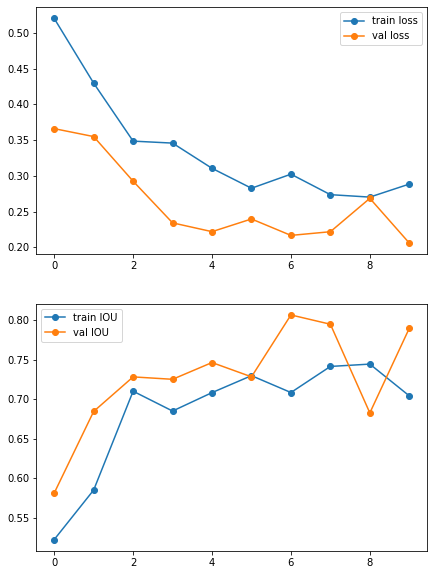

In [37]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (7,10))

ax[0].plot(train_dict['train_loss'],'o-',label = 'train loss')
ax[0].plot(train_dict['val_loss'],'o-',label = 'val loss')
ax[0].legend()

ax[1].plot(train_dict['train_iou'],'o-',label = 'train IOU')
ax[1].plot(train_dict['val_iou'],'o-',label = 'val IOU')
ax[1].legend();

Now that we've trained the output layers, let's try to fine-tune the initial layers by allowing their gradients to be updated.

In [39]:
for name, param in unet.named_parameters():
  if param.requires_grad == False:
    param.requires_grad = True

optimizer = torch.optim.SGD(unet.parameters(), lr=1e-3, momentum = 0.9)
scheduler = PolynomialLR(optimizer)
train_dict = training_loop(10, train_dataloader, val_dataloader, unet, torch.nn.CrossEntropyLoss(), optimizer, scheduler)

Epoch 0
train loss: 0.28026
train IOU: 0.64853
val loss: 0.19944
val IOU: 0.73665
Epoch 1
train loss: 0.26384
train IOU: 0.74314
val loss: 0.24779
val IOU: 0.74223
Epoch 2
train loss: 0.22968
train IOU: 0.79938
val loss: 0.30987
val IOU: 0.68130
Epoch 3
train loss: 0.23862
train IOU: 0.77883
val loss: 0.22628
val IOU: 0.79072
Epoch 4
train loss: 0.22009
train IOU: 0.78118
val loss: 0.21677
val IOU: 0.80238
Epoch 5
train loss: 0.22829
train IOU: 0.76205
val loss: 0.21069
val IOU: 0.78459
Epoch 6
train loss: 0.20293
train IOU: 0.80713
val loss: 0.22541
val IOU: 0.76444
Epoch 7
train loss: 0.23574
train IOU: 0.77857
val loss: 0.21071
val IOU: 0.78580
Epoch 8
train loss: 0.25427
train IOU: 0.74959
val loss: 0.20223
val IOU: 0.77744
Epoch 9
train loss: 0.27451
train IOU: 0.76452
val loss: 0.23111
val IOU: 0.73994


Let's apply our trained model to a few images in the validation dataset, and plot the results.

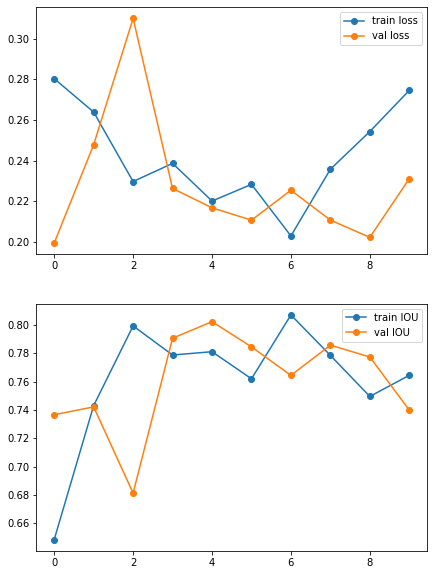

In [40]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (7,10))

ax[0].plot(train_dict['train_loss'],'o-',label = 'train loss')
ax[0].plot(train_dict['val_loss'],'o-',label = 'val loss')
ax[0].legend()

ax[1].plot(train_dict['train_iou'],'o-',label = 'train IOU')
ax[1].plot(train_dict['val_iou'],'o-',label = 'val IOU')
ax[1].legend();

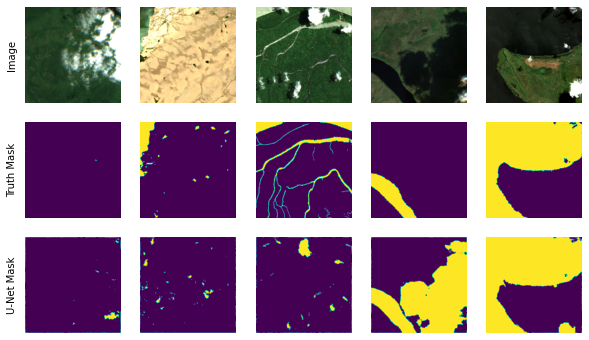

In [72]:
num_examples = 5

fig, ax = plt.subplots(nrows = 3, ncols = num_examples, figsize = (10,6))

val_batch = next(iter(val_dataloader))

img = revert_scale(val_batch)['image']
pred = torch.argmax(unet(img.cuda()), dim = 1).cpu().numpy()
mask = val_batch['mask'].squeeze()

for i in range(num_examples):
  ax[0,i].imshow(img[i].clamp(min = 0, max = 1).cpu().numpy().transpose((1,2,0)))
  ax[1,i].imshow(mask[i])
  ax[2,i].imshow(pred[i])
  for j in range(3):
    ax[j,i].get_xaxis().set_ticks([])
    ax[j,i].get_yaxis().set_ticks([])
    for spine in ax[j,i].spines.values():
        spine.set_visible(False)
ax[0,0].set_ylabel('Image')
ax[1,0].set_ylabel('Truth Mask')
ax[2,0].set_ylabel('U-Net Mask');